# Tarea 1 - Regresión

- Di Carlo, Martina
- Pastrana Analía
- Suárez Gilda

In [1]:
import pandas as pd

#modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score

#roots
from pyprojroot import here

#gráficos
import seaborn as sns
import matplotlib.pyplot as plt

#dates
from datetime import date, timedelta

In [2]:
path = here('Martu') / 'Maestria' / 'data_mining' / 'practico' / 'Datos' /'original' /'Rossman'
path_save = here('Martu') / 'Maestria' / 'data_mining' / 'practico' / 'Datos' / 'generated'

In [3]:
#El dataset Rossman_train.csv contiene los datos para realizar las predicciones de las ventas, presentes en la variable “Sales”.
rossman_train = pd.read_csv(path / 'Rossman_train.csv',
                                      sep=',',
                            quotechar= '"',
                            low_memory=False
                                     )

In [4]:
rossman_train.head() 

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


## EDA

In [5]:
rossman_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [6]:
rossman_train.shape[0]

1017209

Vemos que no tenemos datos nulos.

### Store

In [7]:
rossman_train.Store.drop_duplicates()

0          1
1          2
2          3
3          4
4          5
        ... 
1110    1111
1111    1112
1112    1113
1113    1114
1114    1115
Name: Store, Length: 1115, dtype: int64

In [8]:
print(f'Tenemos {max(rossman_train.Store)} tiendas distintas en nuestro DF de train')

Tenemos 1115 tiendas distintas en nuestro DF de train


In [9]:
counts_tienda = rossman_train.groupby(by = 'Store', dropna = False).size().reset_index(name='counts')
counts_tienda

,Store,counts
0,1,942
1,2,942
2,3,942
3,4,942
4,5,942
...,...,...
1110,1111,942
1111,1112,942
1112,1113,942
1113,1114,942


Parece que muchos stores tienen 942 registros. Validemoslo:

In [10]:
not_942 = counts_tienda.counts != 942
counts_tienda[not_942]

,Store,counts
12,13,758
19,20,758
21,22,758
31,32,758
35,36,758
...,...,...
1093,1094,758
1101,1102,758
1103,1104,758
1106,1107,758


Son 181 que no tienen 942 observaciones. El resto parecen tener todas 758. Lo validamos:

In [11]:
yes_758 = counts_tienda.counts == 758
counts_tienda[yes_758]

,Store,counts
12,13,758
19,20,758
21,22,758
31,32,758
35,36,758
...,...,...
1093,1094,758
1101,1102,758
1103,1104,758
1106,1107,758


Vemos que solo una tienda no aparece ni 942 ni 758 veces. Vemos cual es:

In [12]:
counts_tienda[~yes_758 & not_942]

,Store,counts
987,988,941


Es el store 988.

### Date

Pasamos el dato de fecha de object a tipo datetime:

In [13]:
rossman_train["Date"] = pd.to_datetime(rossman_train["Date"])

In [14]:
rossman_train["Date"].value_counts()

2015-01-30    1115
2015-03-19    1115
2015-05-14    1115
2014-03-10    1115
2013-01-04    1115
              ... 
2014-10-02     935
2014-10-09     935
2014-09-01     935
2014-11-11     935
2014-08-21     935
Name: Date, Length: 942, dtype: int64

Evidentemente tenemos 1 registro por tienda por día.

### StateHoliday

In [15]:
rossman_train.StateHoliday.value_counts()

0    986159
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

In [16]:
rossman_train.StateHoliday.isna().sum()

0

Vemos que tenemos 986159 casos sin el dato correcto de StateHoliday. 

In [17]:
df = rossman_train.copy()

## Open

In [18]:
df.Open.value_counts()

1    844392
0    172817
Name: Open, dtype: int64

In [19]:
df.query("Open == 0 & Sales != 0")

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday


_______________________________
## 1) 
Separar los datos de ventas por tienda y por dia. Esto significa asociar las ventas de cada tienda con igual id en un contenedor. Luego, de forma independiente al procedimiento anterior, obtener el promedio de ventas de cada día. Realizar un plot de las ventas de los primeros 60 días de la tienda 1 y del promedio de ventas también de los primeros 60 días. Los ejes deben ser Tiempo vs. Ventas en ambos casos.

In [20]:
dicc_x_tienda = {id: df[df.Store == id] for id in df.Store.unique()}

In [21]:
store_1 = df.Store == 1
fecha_max_60 = timedelta(days = 60) + min(df[store_1].Date)
first_60 = df.Date <= fecha_max_60

In [22]:
mean_sales_60 = df.loc[first_60].groupby(by = [ 'Date'])['Sales'].mean().reset_index()


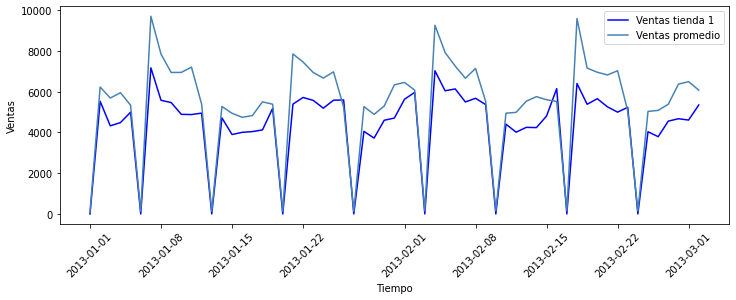

In [23]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.lineplot(data = dicc_x_tienda[1].loc[first_60],
            x = 'Date',
            y = 'Sales',
            color = 'blue',
            label='Ventas tienda 1')
sns.lineplot(data = mean_sales_60,
            x = 'Date',
            y = 'Sales',
            color = 'steelblue',
            label='Ventas promedio')
plt.xlabel("Tiempo")
plt.xticks(rotation=45)
plt.ylabel("Ventas")
plt.show()

### 2) Train y Test  
Dividir los datos originales en Train y Test. Seleccionar los últimos 10 días
para realizar tests sobre el modelo. (0.25 pts)

In [24]:
fecha_min_10 =  max(df[store_1].Date) - timedelta(days = 10)
last_10 = df.Date > fecha_min_10

In [25]:
df = pd.get_dummies(df, columns=['StateHoliday'])
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c
0,1,5,2015-07-31,5263,555,1,1,1,1,0,0,0
1,2,5,2015-07-31,6064,625,1,1,1,1,0,0,0
2,3,5,2015-07-31,8314,821,1,1,1,1,0,0,0
3,4,5,2015-07-31,13995,1498,1,1,1,1,0,0,0
4,5,5,2015-07-31,4822,559,1,1,1,1,0,0,0


In [26]:
df_original = df[~ last_10]
df_test = df[last_10]

In [27]:
X = df_original.drop(['Sales', 'Date'], axis =  1).copy()
y = df_original.Sales

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [28]:
X_train.head()

,Store,DayOfWeek,Customers,Open,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c
337509,187,7,0,0,0,0,1,0,0,0
104548,854,3,680,1,1,0,1,0,0,0
883530,121,2,649,1,1,0,1,0,0,0
283693,678,2,886,1,1,0,1,0,0,0
731633,979,6,566,1,0,0,1,0,0,0


In [29]:
y_train.head()

337509       0
104548    6840
883530    5714
283693    7665
731633    4773
Name: Sales, dtype: int64

### 3)  Modelo de Regresión Lineal  
Seleccione y entrene un modelo de regresión lineal. Justifique brevemente porque eligió dicho modelo. Informe los scores de train y test del modelo. (1.0 pts)


Explicar brevemente porque elegimos este modelo

In [30]:
lr = Lasso()
lr.fit(X_train.values, y_train.values)

Lasso()

In [31]:
y_pred = lr.predict(X_test.values)
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'R2: {r2_score(y_test, y_pred)}')

MSE: 2184959.918439884
R2: 0.8530437252300871


### 4) 
Considere que la variable open = 0 implica y = 0. Realice nuevamente 3 y compare los resultados. Comente, brevemente e informe los scores del modelo. (1.5 pts)

In [32]:
X_test.shape[0]

251515

In [33]:
len(y_pred)

251515

In [37]:
X_test.loc[:, 'predicted'] = y_pred

C:\Users\dicarlom\Miniconda3\envs\data_mining\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [38]:
X_test.loc[X_test['Open'] == 0, 'predicted'] = 0

C:\Users\dicarlom\Miniconda3\envs\data_mining\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [39]:
X_test.query('Open == 0').predicted.sum()

0.0

In [40]:
X_test.head(1)

,Store,DayOfWeek,Customers,Open,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,predicted
930994,755,2,969,1,1,0,1,0,0,0,8982.920459


In [41]:
print(f'MSE: {mean_squared_error(y_test, X_test.predicted)}')
print(f'R2: {r2_score(y_test, X_test.predicted)}')

MSE: 2173856.4191093715
R2: 0.8537905256106119


A la vista del resultado podemos afirmar que el ajuste inicial era bueno con un R cuadrado de  0.85  y es cercano a 1, en concreto, el 85% de la variabilidad de la variable Y a su promedio es explicado por el modelo de regresión ajustado. Podemos concluir que el modelo lineal es adecuado para describir la relación
que existe entre estas variables.Cuando probamos con open == 0, target -> 0 vemos que mejora un poco la predicción.

### 5) Predicción sobre los datos de test. 
Genere un plot que contraste las ventas verdaderas contra las ventas predichas por el modelo vs. la fecha. Realice
esto con el promedio de ventas por día y para las tiendas 1 y 100. (1.0 pts)

#### Predicciones sobre test

In [35]:
pred_test = lr_bis.predict(df_test.drop(['Sales', 'Date'], axis =  1).copy().values)

In [36]:
list_test_pred = pred_test.tolist()
list_test_pred[:10]

[6464.204674076895,
 6888.37360721196,
 8076.379717439458,
 12180.303940218231,
 6487.713256795634,
 6669.394197202942,
 11670.523993074416,
 8148.200844565239,
 7262.9346169704195,
 7226.376363922746]

#### Datos reales de test

In [37]:
df_test.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c
0,1,5,2015-07-31,5263,555,1,1,1,1,0,0,0
1,2,5,2015-07-31,6064,625,1,1,1,1,0,0,0
2,3,5,2015-07-31,8314,821,1,1,1,1,0,0,0
3,4,5,2015-07-31,13995,1498,1,1,1,1,0,0,0
4,5,5,2015-07-31,4822,559,1,1,1,1,0,0,0


#### DF con datos reales mas predicciones

In [38]:
df_test.insert(4, 'Predicted_Sales', list_test_pred , True)
df_test.head()

,Store,DayOfWeek,Date,Sales,Predicted_Sales,Customers,Open,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c
0,1,5,2015-07-31,5263,6464.204674,555,1,1,1,1,0,0,0
1,2,5,2015-07-31,6064,6888.373607,625,1,1,1,1,0,0,0
2,3,5,2015-07-31,8314,8076.379717,821,1,1,1,1,0,0,0
3,4,5,2015-07-31,13995,12180.303940,1498,1,1,1,1,0,0,0
4,5,5,2015-07-31,4822,6487.713257,559,1,1,1,1,0,0,0


In [39]:
def plot_pred_vs_real(df, real, predicted, label_real, label_predicted, c_real, c_predicted):

    fig, ax = plt.subplots(figsize=(12, 4))

    sns.lineplot(data = df,
                x = 'Date',
                y = real,
                color = c_real,
                label=label_real)

    sns.lineplot(data = df,
                x = 'Date',
                y = predicted,
                color = c_predicted,
                label=label_predicted)

    plt.xlabel("Tiempo")
    plt.xticks(rotation=45)
    plt.ylabel("Ventas")
    plt.show()

### Predicted vs promedio ventas por día 

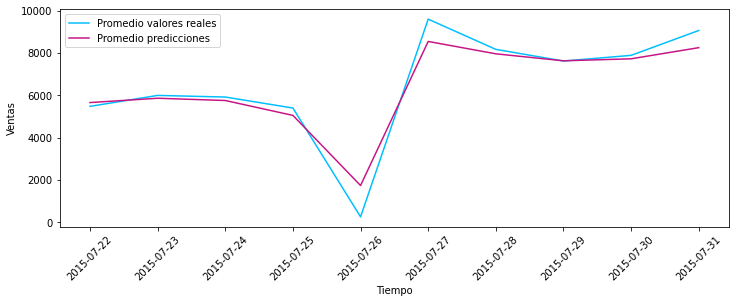

In [40]:
test_gruped_mean = df_test.groupby(by = ['Date'])[['Sales', 'Predicted_Sales']].mean().reset_index()
plot_pred_vs_real(test_gruped_mean, 
                  'Sales', 
                  'Predicted_Sales', 
                  'Promedio valores reales', 
                  'Promedio predicciones',
                  'deepskyblue',
                  'mediumvioletred')

### Predicted vs tienda 1

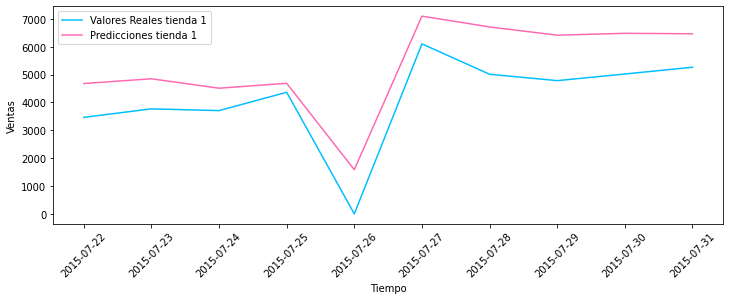

In [41]:
tienda_1 = df_test.Store == 1
plot_pred_vs_real(df_test[tienda_1], 
                  'Sales', 
                  'Predicted_Sales', 
                  'Valores Reales tienda 1', 
                  'Predicciones tienda 1',
                  'deepskyblue',
                 'hotpink')

### Predicted vs tienda 100

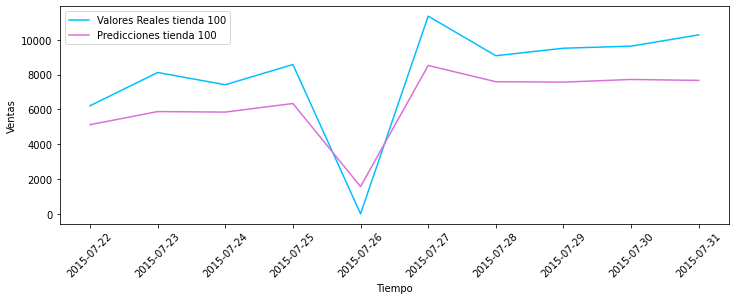

In [42]:
tienda_100 = df_test.Store == 100
plot_pred_vs_real(df_test[tienda_100], 
                  'Sales', 
                  'Predicted_Sales', 
                  'Valores Reales tienda 100', 
                  'Predicciones tienda 100',
                  'deepskyblue',
                  'orchid')
                 

## 6) Opcional Rossman Store

In [43]:
#El dataset Rossman_store.csv contiene información extra para la consigna opcional.
rossman_store = pd.read_csv(path / 'Rossman_store.csv',
                                     header=0, 
                                      sep=','
                                     )

In [44]:
rossman_store.head(1)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


In [45]:
df.head(1)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c
0,1,5,2015-07-31,5263,555,1,1,1,1,0,0,0


In [46]:
df = df.merge(rossman_store[['Store', 'StoreType','Assortment']], 
              how = 'inner',
              left_on = 'Store',
              right_on = 'Store')


In [68]:
df['clase'] = 'StoreType_' +df['StoreType'].astype(str) + '_Assortment_' + df['Assortment'].astype(str)

In [69]:
df['clase'].value_counts()

StoreType_a_Assortment_a    346389
StoreType_a_Assortment_c    205238
StoreType_d_Assortment_c    199328
StoreType_d_Assortment_a    113584
StoreType_c_Assortment_a     70878
StoreType_c_Assortment_c     65962
StoreType_b_Assortment_b      8294
StoreType_b_Assortment_a      6594
StoreType_b_Assortment_c       942
Name: clase, dtype: int64

In [77]:
dicc_st_ass = {id: df[df.clase == id] for id in df.clase.unique()}

In [85]:
dicc_pred_st_ass = {}
for key in dicc_st_ass:
    
    fecha_min_10 =  max(dicc_st_ass[key].Date) - timedelta(days = 10)
    last_10 = dicc_st_ass[key].Date > fecha_min_10
    
    dataset = dicc_st_ass[key]
    dataset_original = dataset[~ last_10]
    dataset_test = dataset[last_10]
    
    X1 = dataset_original.drop(['Sales', 'Date', 'StoreType','Assortment', 'class','clase'], axis =  1).copy()
    y1 = dataset_original.Sales

    X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1)
    
    lasso = Lasso()
    lasso.fit(X1_train.values, y1_train.values)
    dicc = {}
    dicc['valores_predichos'] = lasso.predict(X1_test.values)
    dicc['MSE'] = mean_squared_error(y1_test, dicc['valores_predichos'])
    dicc['R2'] = r2_score(y1_test, dicc['valores_predichos'])
    
    dicc_pred_st_ass[key] = dicc


In [98]:
for key in dicc_pred_st_ass:
    MSE = dicc_pred_st_ass[key]['MSE']
    r2 = dicc_pred_st_ass[key]['R2']
    print(f'El MSE de nuestro modelo {key} es {round(MSE,3)} ')
    print(f'El MSE de nuestro modelo {key} es {round(r2,3)} ')
    print('--------------')


El MSE de nuestro modelo StoreType_c_Assortment_a es 995217.175 
El MSE de nuestro modelo StoreType_c_Assortment_a es 0.918 
--------------
El MSE de nuestro modelo StoreType_a_Assortment_a es 1189399.181 
El MSE de nuestro modelo StoreType_a_Assortment_a es 0.914 
--------------
El MSE de nuestro modelo StoreType_c_Assortment_c es 1277025.731 
El MSE de nuestro modelo StoreType_c_Assortment_c es 0.918 
--------------
El MSE de nuestro modelo StoreType_a_Assortment_c es 1631121.395 
El MSE de nuestro modelo StoreType_a_Assortment_c es 0.911 
--------------
El MSE de nuestro modelo StoreType_d_Assortment_a es 971496.316 
El MSE de nuestro modelo StoreType_d_Assortment_a es 0.91 
--------------
El MSE de nuestro modelo StoreType_d_Assortment_c es 1380088.197 
El MSE de nuestro modelo StoreType_d_Assortment_c es 0.892 
--------------
El MSE de nuestro modelo StoreType_b_Assortment_a es 1703223.795 
El MSE de nuestro modelo StoreType_b_Assortment_a es 0.95 
--------------
El MSE de nuestro

Podemos ver aqui que claramente cada clase de store tiene un comportamiento distinto, por lo que este experimento de crear 9 modelos mejora los valores del modelo creado antes, generando mejores predicciones.